In [1]:
# from circuit_suite import circuits
# # from backend_suite import backends, large_backends, shuffle_test, routing_test
# #from backend_suite import placement_test


In [2]:
# from backend_suite import backends
# backends["Hatlab-Large-Riswap-Dense"].pass_manager.run(circuits["QFT"].circuit_lambda(4))


In [3]:
# from backend_suite_v2 import motivation_backends
# from circuit_suite import circuits

# import numpy as np

# # for circuit_gen in circuits.values():
# #     benchmark(
# #         backends=motivation_backends,
# #         circuit_generator=circuit_gen,
# #         continuously_save=True,
# #         overwrite=False,
# #         repeat=1
# #     )

# backends = motivation_backends


# def average_compare(backends, backend1, backend2):
#     print(f"Find ratio {backend1}/{backend2}")
#     for circuit_label in circuits.keys():
#         print(circuit_label)
#         for backend in backends:
#             a = [
#                 sum([jel for k, jel in el.items() if k in ["swap"]])#, "cx", "riswap"]])
#                 for z, el in backend.data["0"][circuit_label]["preswap_gate_count"].items()
#                 if int(z) >= 80
#             ]
#             if backend.label in [backend1]:
#                 num = a
#             elif backend.label in [backend2]:
#                 den = a

#         ratio = np.array(num) / np.array(den)
#         mean = np.mean(ratio)
#         std = np.std(ratio)
#         print(mean,'+/-', std)


# average_compare(backends, "Heavy-Hex", "Modular")
# # edge_histogram(decomp_backends, circuit_gen.label)
# # circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
# # plot_wrap(motivation_backends, circuits.keys(), motivation=True, plot_average=True)


## Circuit Transpile Benchmark

In [4]:
# make a plot :)
import matplotlib.pyplot as plt


def benchmark(
    backends,
    circuit_generator,
    q_range=None,
    continuously_save=False,
    overwrite=False,
    repeat=3,
):
    for iteration in range(repeat):
        benchmark_foo(
            iteration,
            backends,
            circuit_generator,
            q_range,
            continuously_save,
            overwrite,
        )


def benchmark_foo(
    i,
    backends,
    circuit_generator,
    q_range=None,
    continuously_save=False,
    overwrite=False,
):
    iteration = str(i)
    # override qrange if provided
    if q_range is None:
        q_range = circuit_generator.q_range

    # check if data dicts are empty
    for backend in backends:
        if not iteration in backend.data.keys():
            backend.data[iteration] = {}
        if not circuit_generator.label in backend.data[iteration].keys():
            backend.data[iteration][circuit_generator.label] = {}
            backend.data[iteration][circuit_generator.label]["duration"] = {}
            backend.data[iteration][circuit_generator.label]["preswap_gate_count"] = {}
            backend.data[iteration][circuit_generator.label]["gate_count"] = {}
            backend.data[iteration][circuit_generator.label][
                "preswap_gate_count_crit"
            ] = {}
            backend.data[iteration][circuit_generator.label]["layout_score"] = {}
            backend.data[iteration][circuit_generator.label]["edge_frequency"] = {}
    print(f"Starting benchmark for {circuit_generator.label}")

    # outer loop over circuit since this may take long time to generate
    for q in q_range:
        # create new variable sized lambda circuit
        # wait to build circuit (may be costly), if we end up not needing it for any backend
        qc = None
        if overwrite:
            qc = circuit_generator.circuit_lambda(q)

        for backend in backends:

            # condition to skip
            if not overwrite:
                # convert to int because if loaded from json key will be a string
                if q in [
                    int(k)
                    for k in backend.data[iteration][circuit_generator.label][
                        "preswap_gate_count"
                    ].keys()
                ]:
                    continue

            # resolve wait
            if qc is None:
                qc = circuit_generator.circuit_lambda(q)

            # logging.info(f"Transpiler qc{q} for {backend.label}")
            print(f"Transpiler qc{q} for {backend.label}")
            backend.pass_manager.run(qc)

            # save data to dict
            # might be empty if not decomposing swaps, this comment is deprecated
            # if (
            #     "duration_longest_path_length"
            #     in backend.pass_manager.property_set.keys()
            # ):

            #switch to using standard count ops method now w/o pulse normalization arg
            duration = backend.pass_manager.property_set[
                "count_ops_longest_path"
            ]
            backend.data[iteration][circuit_generator.label]["duration"][str(q)] = duration

            gate_count = backend.pass_manager.property_set["preswap_count_ops"]
            backend.data[iteration][circuit_generator.label]["preswap_gate_count"][
                str(q)
            ] = gate_count

            gate_count_critical_path = backend.pass_manager.property_set[
                "preswap_count_ops_longest_path"
            ]
            backend.data[iteration][circuit_generator.label]["preswap_gate_count_crit"][
                str(q)
            ] = gate_count_critical_path

            gate_count_post_decomp = backend.pass_manager.property_set["count_ops"]
            backend.data[iteration][circuit_generator.label]["gate_count"][
                str(q)
            ] = gate_count_post_decomp

            layout_score = backend.pass_manager.property_set["layout_score"]
            backend.data[iteration][circuit_generator.label]["layout_score"][
                str(q)
            ] = float(layout_score)

            frequency_list = backend.pass_manager.property_set["edge_frequency"]
            backend.data[iteration][circuit_generator.label]["edge_frequency"][
                str(q)
            ] = frequency_list

            # for long tests, may want to save more regularly in case exit early
            if continuously_save:
                backend.save_json()

    for backend in backends:
        # save dict to json
        backend.save_json()


In [5]:
# !pip install SciencePlots
# import matplotlib.pyplot as plt
# plt.style.reload_library()
# plt.style.use(['science','no-latex'])

In [49]:
def plot_wrap(backends, circuit_label_list, motivation=False,plot_average=True):
    # fig, axs = plt.subplots(len(circuit_label_list),4, figsize=(24,24))
    height = 5
    if 1 or motivation:
        height = 2.5
    fig = plt.figure(constrained_layout=True, figsize=(7.16, height))
    plt.style.use(["science"])
    SMALL_SIZE = 4
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 12
    plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
    plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=MEDIUM_SIZE + 4)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=SMALL_SIZE + 2)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=SMALL_SIZE + 2)  # fontsize of the tick labels
    plt.rc("legend", fontsize=MEDIUM_SIZE + 2)  # legend fontsize
    plt.rc("figure", titlesize=MEDIUM_SIZE + 4)  # fontsize of the figure title
    plt.rc("lines", markersize=1.8, linewidth=.75)

    if 1 or motivation:
        nrows = 2
    else:
        nrows = 4
    axs = fig.subplots(ncols=len(circuit_label_list), nrows=nrows)
    i = 0
    for circuit_label in circuit_label_list:
        ax = plot(
            backends,
            circuit_label,
            duration=2,
            subfig=axs,
            first=(i == 0),
            index=i,
            motivation=motivation,
            plot_average=plot_average
            # last=(i + 1 == len(circuit_label_list)),
        )
        i += 1
        circuit_label = circuit_label.replace("_", " ")
        ax.set_xlabel(f"{circuit_label}", y=0)
    # for ax, row in zip(ax[:,0], subfigs):
    #     ax.set_ylabel(row, rotation=0, size='large')
    fig.align_ylabels(axs)
    handles, labels = ax.get_legend_handles_labels()

    # patch labels
    def fix_labels(labels):
        for index, label in enumerate(labels):
            if "small" in label:
                label = label[:-6]
            if label == "Heavy-Hex-cx":
                labels[index] = "Heavy-Hex"#-CX"
            if label == "Hex-Lattice-cx":
                labels[index] = "Hex-Lattice"
            if label == "Lattice+AltDiagonals-cx":
                labels[index] = "Lattice+AltDiagonals"
            if label == "Square-Lattice-syc":
                labels[index] = "Square-Lattice"#-SYC"
            if label == "Modular-riswap":
                labels[index] = r"Tree"#-$\sqrt{iSWAP}$"
            if label == "Modular-RR3-riswap":
                labels[index] = r"Tree-RR"#-$\sqrt{iSWAP}$"
            if label == "Hypercube-riswap":
                labels[index] = r"Hypercube"#-$\sqrt{iSWAP}$"

            if label == "HypercubeSNAIL-(0, 0)-riswap":
                labels[index] = r"Corral$_{1,1}$"
            if label == "HypercubeSNAIL-(0, 1)-riswap":
                labels[index] = r"Corral$_{1,2}$"
        return labels

    labels = fix_labels(labels)

    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=3,
        bbox_to_anchor=(0.5, -0.01),
        markerscale=2,
    )
    # savefig
    filename = f"images/data1"
    import os

    i = 0
    while os.path.exists("{}{:d}.pdf".format(filename, i)):
        i += 1
    fig.savefig("{}{:d}.pdf".format(filename, i), format="pdf", facecolor="white")


In [7]:
import numpy as np

def plot(
    backends,
    circuit_label,
    duration=0,
    subfig=None,
    first=False,
    index=0,
    motivation=False,
    plot_average=True,
):
    def mark(backend_label):
        if "Modular" in backend_label:
            if "RR" in backend_label:
                return 'p'
            return "*"
        if "Google" in backend_label or "Square" in backend_label:
            return "s"
        if "IBM" in backend_label or "Heavy" in backend_label:
            return "h"
        if "Hex-Lattice" in backend_label:
            return "^"
        if "AltDiagonals" in backend_label:
            return "x"
        if "SNAIL" in backend_label:
            if "(0, 1)" in backend_label:
                return 'D'
            return '8'
        if "Hypercube" in backend_label:
            return "o"
        pass
    
    def color_map(backend_label):
        if "Modular" in backend_label:
            if "RR" in backend_label:
                return 'tab:olive'
            return "tab:green"
        if "Google" in backend_label or "Square" in backend_label:
            return "tab:red"
        if "IBM" in backend_label or "Heavy" in backend_label:
            return "tab:blue"
        if "Hex-Lattice" in backend_label:
            return "tab:cyan"
        if "AltDiagonals" in backend_label:
            return "tab:orange"
        if "SNAIL" in backend_label:
            if "(0, 1)" in backend_label:
                return "tab:pink"
            return "tab:purple"
        if "Hypercube" in backend_label:
            return "tab:brown"
        pass

    if subfig is None:
        if duration == 2:
            fig, (ax2, ax3, ax4, ax1) = plt.subplots(1, 4, figsize=(24, 8))
        else:
            raise NotImplementedError
    else:
        # axs = subfig.subplots(nrows=4, ncols=1)
        ax2 = subfig[0][index]
        ax3 = subfig[1][index]
        if not motivation:
            pass
            # ax4 = subfig[2][index]
            # ax1 = subfig[3][index]
        if 1 or motivation:
            ax_list = [ax2, ax3]
        else:
            ax_list = [ax2, ax3, ax4, ax1]
        for ax in ax_list:
            # ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    # elif duration==1:
    #     fig, (ax1) = plt.subplots(1,1, figsize=(12,8))
    # else:
    #     fig, (ax2, ax3) = plt.subplots(1,2, figsize=(24,8))
    for backend in backends:
        if circuit_label in backend.data["0"].keys():
            if motivation:
                # total swap gates
                x = backend.data["0"][circuit_label]["preswap_gate_count"].keys()
                x = [int(el) for el in list(x)]
                y_best = np.ones(len(x)) * np.inf
                y_average = np.zeros(len(x))
                for iter_key in backend.data.keys():
                    y = backend.data[iter_key][circuit_label][
                        "preswap_gate_count"
                    ].values()
                    x, y = zip(*zip(x, y))
                    y = [el["swap"] if "swap" in el.keys() else 0 for el in y]
                    #XXX monkey patch
                    x =list(x)
                    y=list(y)
                    if len(x) > 10:
                        for val in [4,6,10,12,14]:
                            del_index = x.index(val)
                            x.pop(del_index)
                            y.pop(del_index)
                    
                    x, y = zip(*sorted(zip(x, y)))
                
                    for index, el in enumerate(y):
                        if y_best[index] > el:
                            y_best[index] = el
                        y_average[index] += el
                y_average /= len(backend.data.keys())
                y_average = y_average[0:len(x)]
                if plot_average:
                    y = y_average
                else:
                    y = y_best
                ax2.plot(x, y, marker=mark(backend.label), label=backend.label, color=color_map(backend.label))
                # ax2.set_ylabel("Total SWAP Count")
                # if last:
                #     ax2.set_xlabel("Num Qubits")
                if not duration == 2:
                    ax2.legend()
                if first:
                    ax2.set_ylabel("Total SWAP Count")  # vs Num Qubits")

            if motivation:
                # critical path swap gates
                x = backend.data["0"][circuit_label]["preswap_gate_count_crit"].keys()
                x = [int(el) for el in list(x)]
                y_best = np.ones(len(x)) * np.inf
                y_average = np.zeros(len(x))
                for iter_key in backend.data.keys():
                    y = backend.data[iter_key][circuit_label][
                        "preswap_gate_count_crit"
                    ].values()
                    x, y = zip(*zip(x, y))
                    y = [el["swap"] if "swap" in el.keys() else 0 for el in y]
                    #XXX monkey patch
                    x =list(x)
                    y=list(y)
                    if len(x) > 10:
                        for val in [4,6,10,12,14]:
                            del_index = x.index(val)
                            x.pop(del_index)
                            y.pop(del_index)
                    x, y = zip(*sorted(zip(x, y)))
            
                    for index, el in enumerate(y):
                        if y_best[index] > el:
                            y_best[index] = el
                        y_average[index] += el
                y_average /= len(backend.data.keys())
                y_average = y_average[0:len(x)]
                if plot_average:
                    y = y_average
                else:
                    y = y_best
                ax3.plot(x, y, marker=mark(backend.label), label=backend.label, color=color_map(backend.label))
                # ax3.set_ylabel("Critical Path SWAP Count")
                # if last:
                #     ax3.set_xlabel("Num Qubits")
                if first:
                    ax3.set_ylabel("Critical Path SWAPs")  #  vs Num Qubits")
                if not duration == 2:
                    ax3.legend()
            if not motivation:
                # critical path swap gates
                x = backend.data["0"][circuit_label]["gate_count"].keys()
                x = [int(el) for el in list(x)]
                y_best = np.ones(len(x)) * np.inf
                y_average = np.zeros(len(x))
                for iter_key in backend.data.keys():
                    y = backend.data[iter_key][circuit_label]["gate_count"].values()
                    x, y = zip(*zip(x, y))
                    twoqgate_list = ["rzx", "riswap", "cx", "syc", "fSim"]
                    for twoqgate in twoqgate_list:
                        temp = [
                            el[twoqgate] if twoqgate in el.keys() else 0 for el in y
                        ]
                        if temp[-1] != 0:
                            y = temp
                            break
                    #XXX monkey patch
                    x =list(x)
                    y=list(y)
                    if len(x) > 10:
                        for val in [4,6,10,12,14]:
                            del_index = x.index(val)
                            x.pop(del_index)
                            y.pop(del_index)

                    x, y = zip(*sorted(zip(x, y)))
                
                    for index, el in enumerate(y):
                        if y_best[index] > el:
                            y_best[index] = el
                        y_average[index] += el
                y_average /= len(backend.data.keys())
                y_average = y_average[0:len(x)]
                if plot_average:
                    y = y_average
                else:
                    y = y_best
                ax2.plot(x, y, marker=mark(backend.label), label=backend.label, color=color_map(backend.label))
                # ax4.set_ylabel("Total 2Q Gate Count")
                # if last:
                #     ax4.set_xlabel("Num Qubits")
                if first:
                    ax2.set_ylabel("Total 2Q Count")  #  vs Num Qubits")
                if not duration == 2:
                    ax2.legend()

            # #duration
            if not motivation:
                x = backend.data["0"][circuit_label]["duration"].keys()
                x = [int(el) for el in list(x)]
                y_best = np.ones(len(x)) * np.inf
                y_average = np.zeros(len(x))
                for iter_key in backend.data.keys():
                    y = backend.data[iter_key][circuit_label]["duration"].values()
                    #XXX monkey patch
                    x =list(x)
                    y = list(y)
                    if len(x) > 10:
                        for val in [4,6,10,12,14]:
                            del_index = x.index(val)
                            x.pop(del_index)
                            y.pop(del_index)
                    x, y = zip(*zip(x, y))
                    twoqgate_list = ["rzx", "riswap", "cx", "syc", "fSim"]
                    for twoqgate in twoqgate_list:
                        temp = [
                            el[twoqgate] if twoqgate in el.keys() else 0 for el in y
                        ]
                        if temp[-1] != 0:
                            y = temp
                            break

                    for index, el in enumerate(y):
                        if y_best[index] > el:
                            y_best[index] = el
                        y_average[index] += el
                y_average /= len(backend.data.keys())
                y_average = y_average[0:len(x)]
                if plot_average:
                    y = y_average
                else:
                    y = y_best

                ax3.plot(x, y, marker=mark(backend.label), label=backend.label, color=color_map(backend.label))
                # ax1.set_ylabel("Critical Path 2Q Pulse Duration")
                # if last:
                #     ax1.set_xlabel("Num Qubits")
                if first:
                    ax3.set_ylabel("Pulse Duration")  #  vs Num Qubits")
    if 1 or motivation:
        return ax3
    return ax1

    # if duration==2:
    # handles, labels = ax1.get_legend_handles_labels()
    # fig.legend(handles, labels)
    # fig.suptitle(circuit_label, fontsize=32)
    # savefig
    # filename = f"images/{circuit_label}"
    # import os
    # i = 0
    # while os.path.exists('{}{:d}.png'.format(filename, i)):
    #     i += 1
    # fig.savefig('{}{:d}.png'.format(filename, i), facecolor='white')


# plot(placement_test, circuit_gen.label, parameter="duration")
# plot(routing_test, circuit_gen.label, parameter="layout_score")


In [8]:
def edge_histogram(backends, circuit_label):
    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for backend in backends:
        if circuit_label in backend.data.keys():
            # for now only make histogram for largest data point available
            max_key = max(
                [int(el) for el in backend.data[circuit_label]["edge_frequency"].keys()]
            )
            frequency_list = backend.data[circuit_label]["edge_frequency"][str(max_key)]

            # sort dictionary
            frequency_list = dict(
                sorted(frequency_list.items(), key=lambda item: item[1], reverse=True)
            )

            ax.scatter(
                range(len(frequency_list.keys())),
                frequency_list.values(),
                label=backend.label,
            )
            for i, key in enumerate(frequency_list.keys()):
                ax.annotate(key, (i, frequency_list[key]))
                if i >= 3:
                    break

    ax.set_ylabel("Edge Frequency")
    ax.set_xlabel("Edge")
    ax.set_title(f"{circuit_label} {max_key}")
    ax.legend()


Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


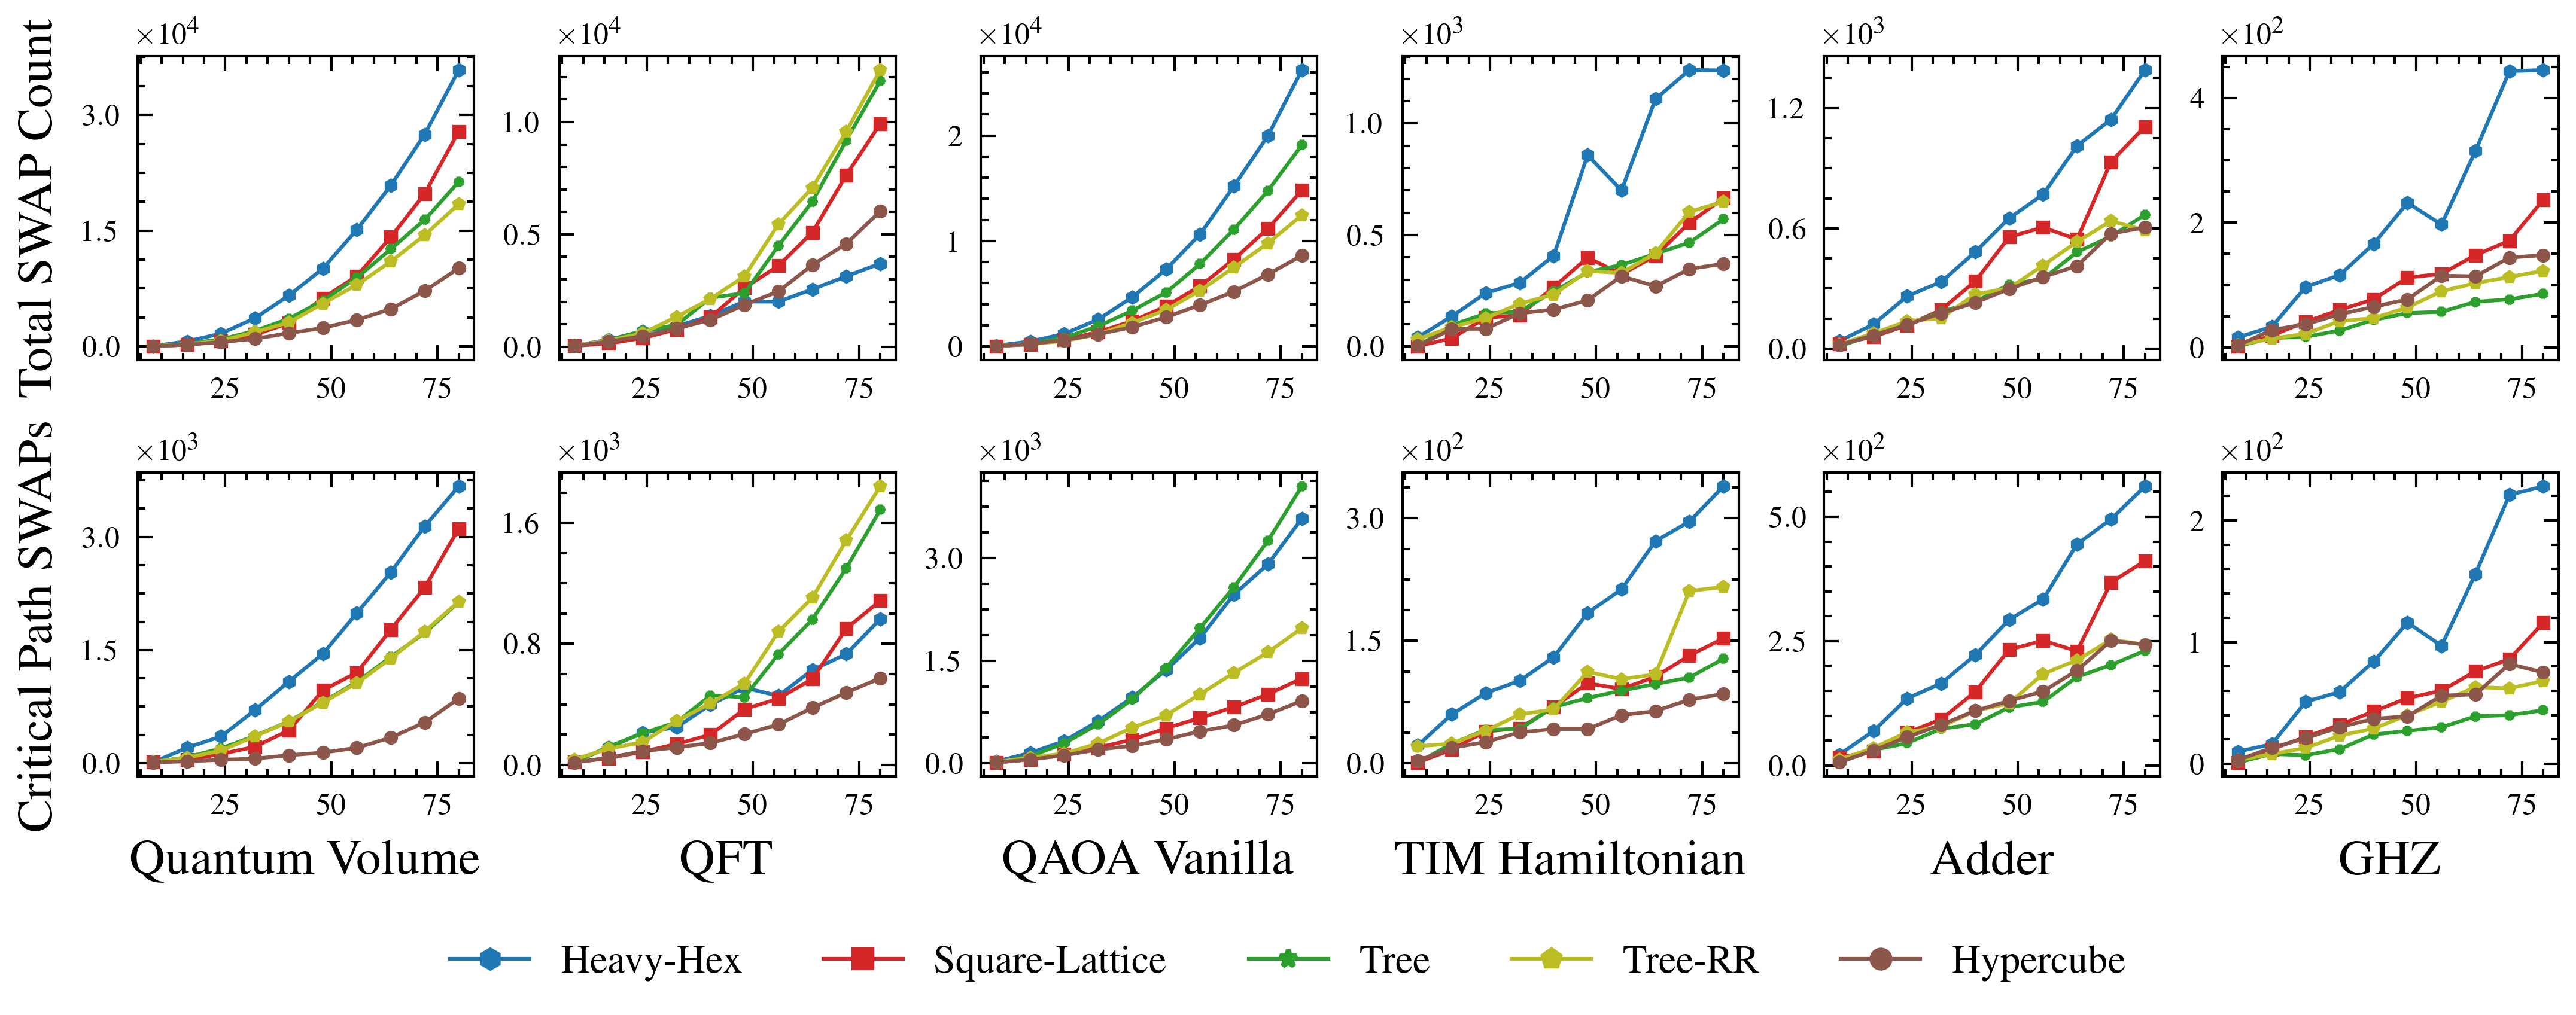

In [28]:
# from backend_suite_v2 import results_backends
# from circuit_suite import circuits
# for circuit_gen in circuits.values():
#     benchmark(
#         backends=results_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=False,
#         repeat=1
#     ) 
# plot_wrap(results_backends, circuits.keys(), motivation=True, plot_average=True)

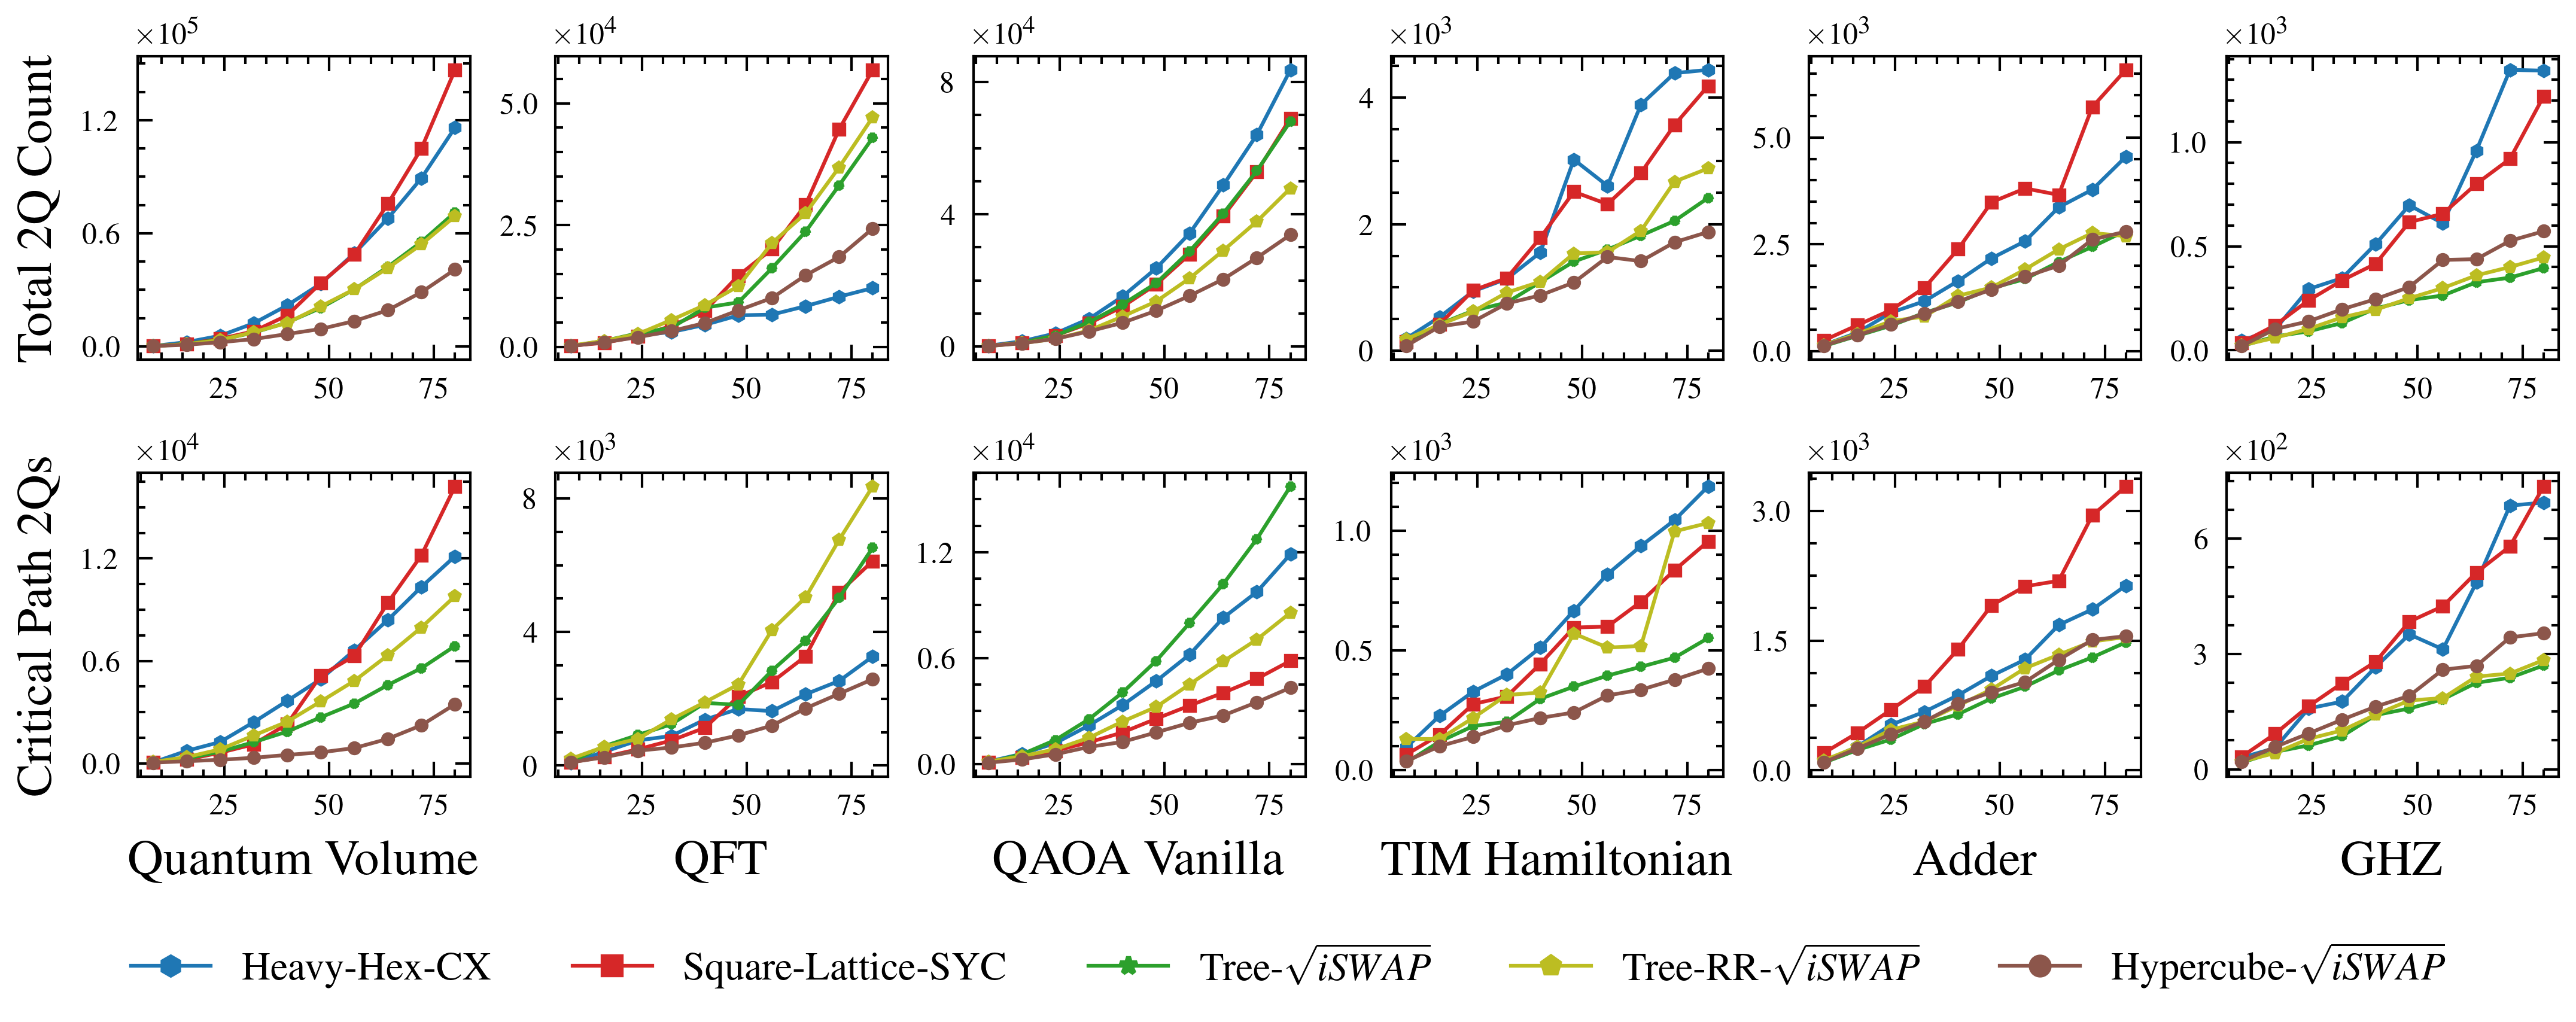

In [31]:
# plot_wrap(results_backends, circuits.keys(), motivation=False, plot_average=True)

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


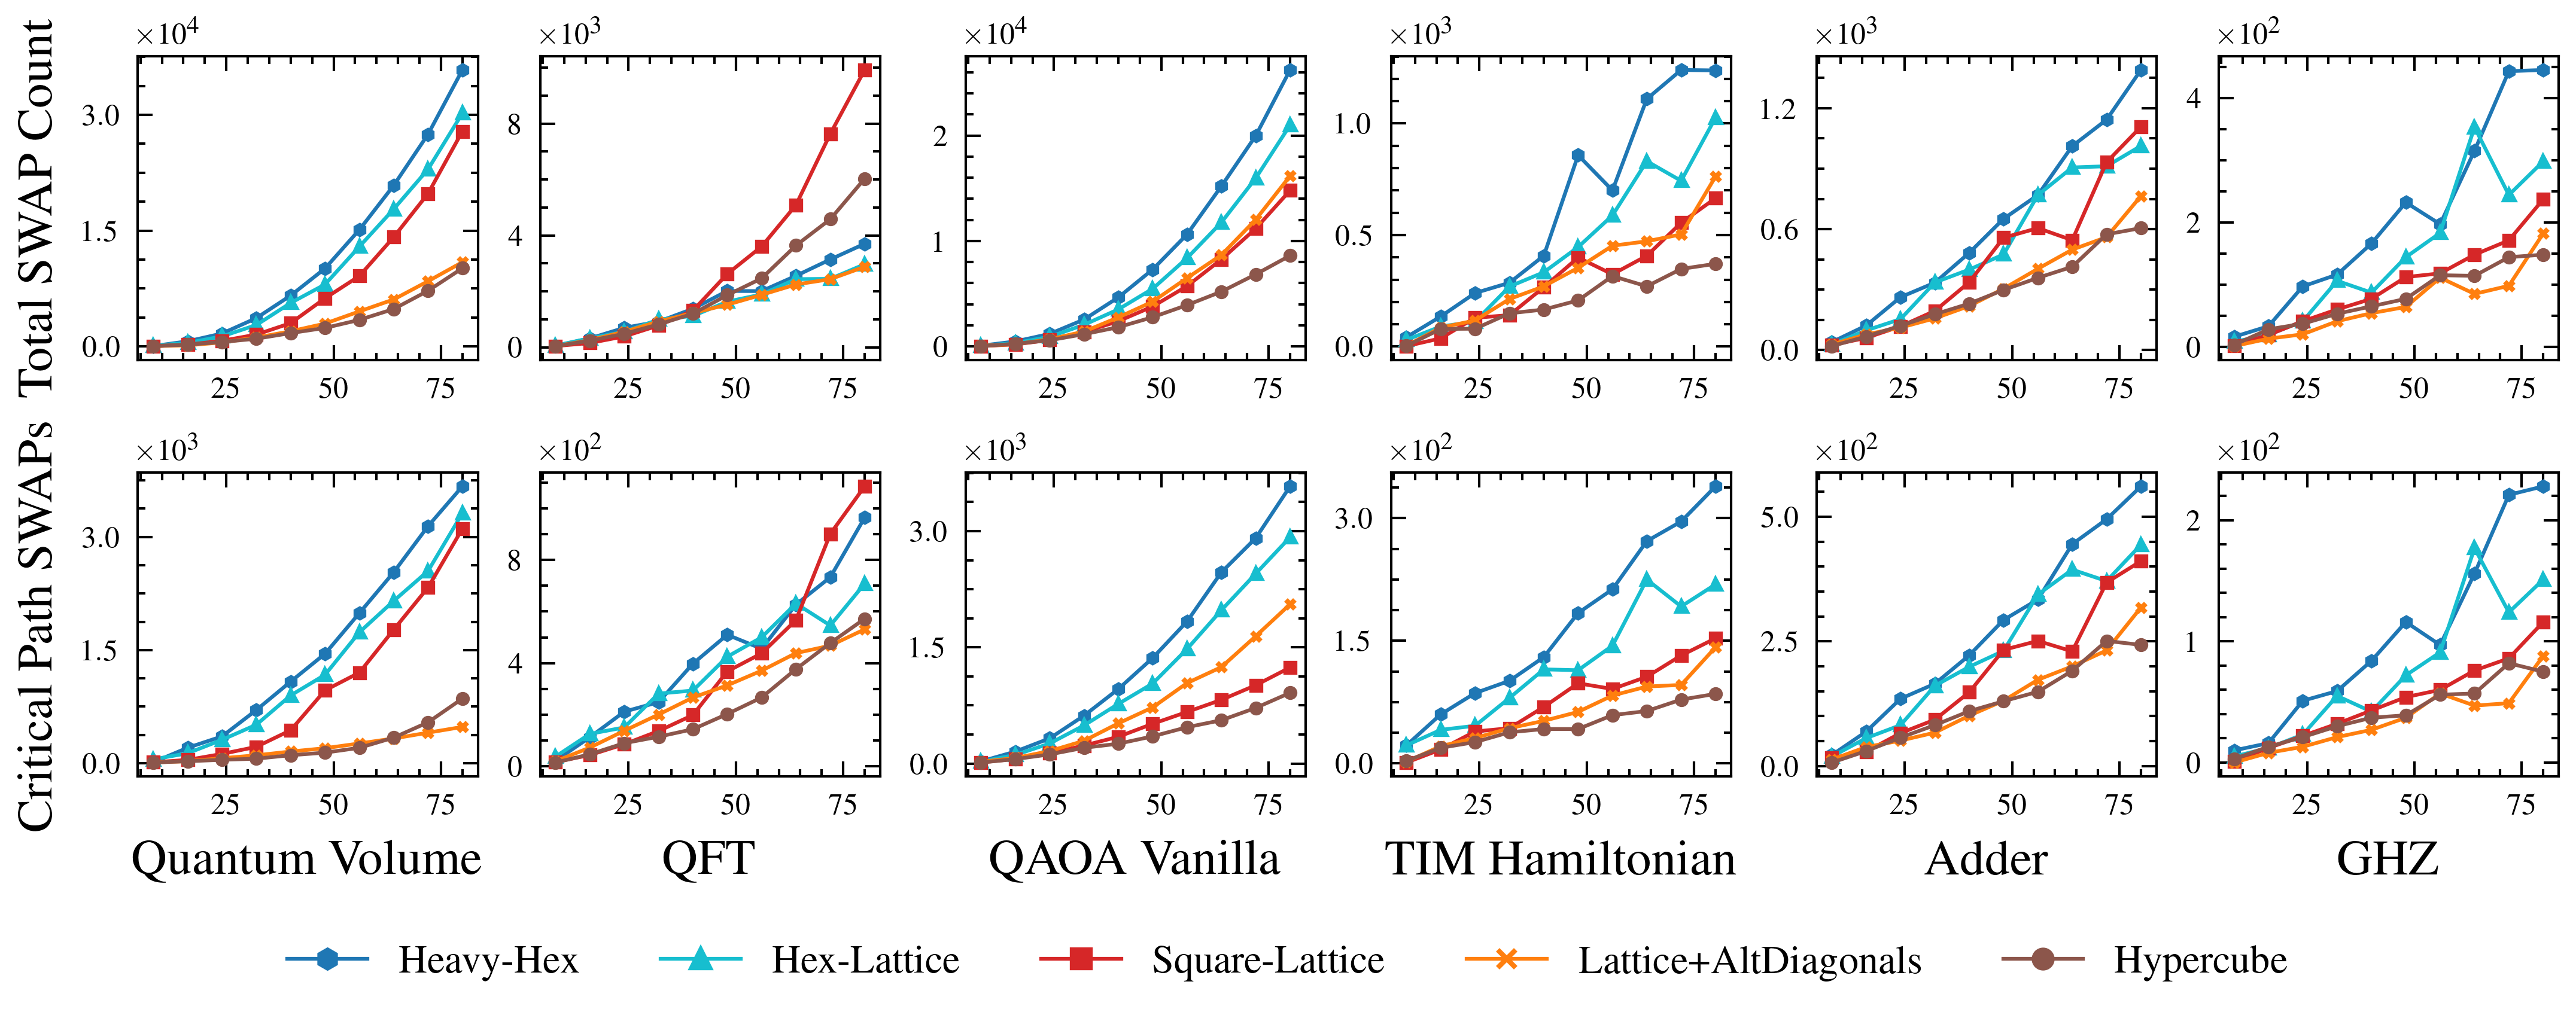

In [35]:
# from backend_suite_v2 import motivation_backends
# from circuit_suite import circuits
# for circuit_gen in circuits.values():
#     benchmark(
#         backends=motivation_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=False,
#         repeat=1
#     ) 
# plot_wrap(motivation_backends, circuits.keys(), motivation=True, plot_average=True)

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


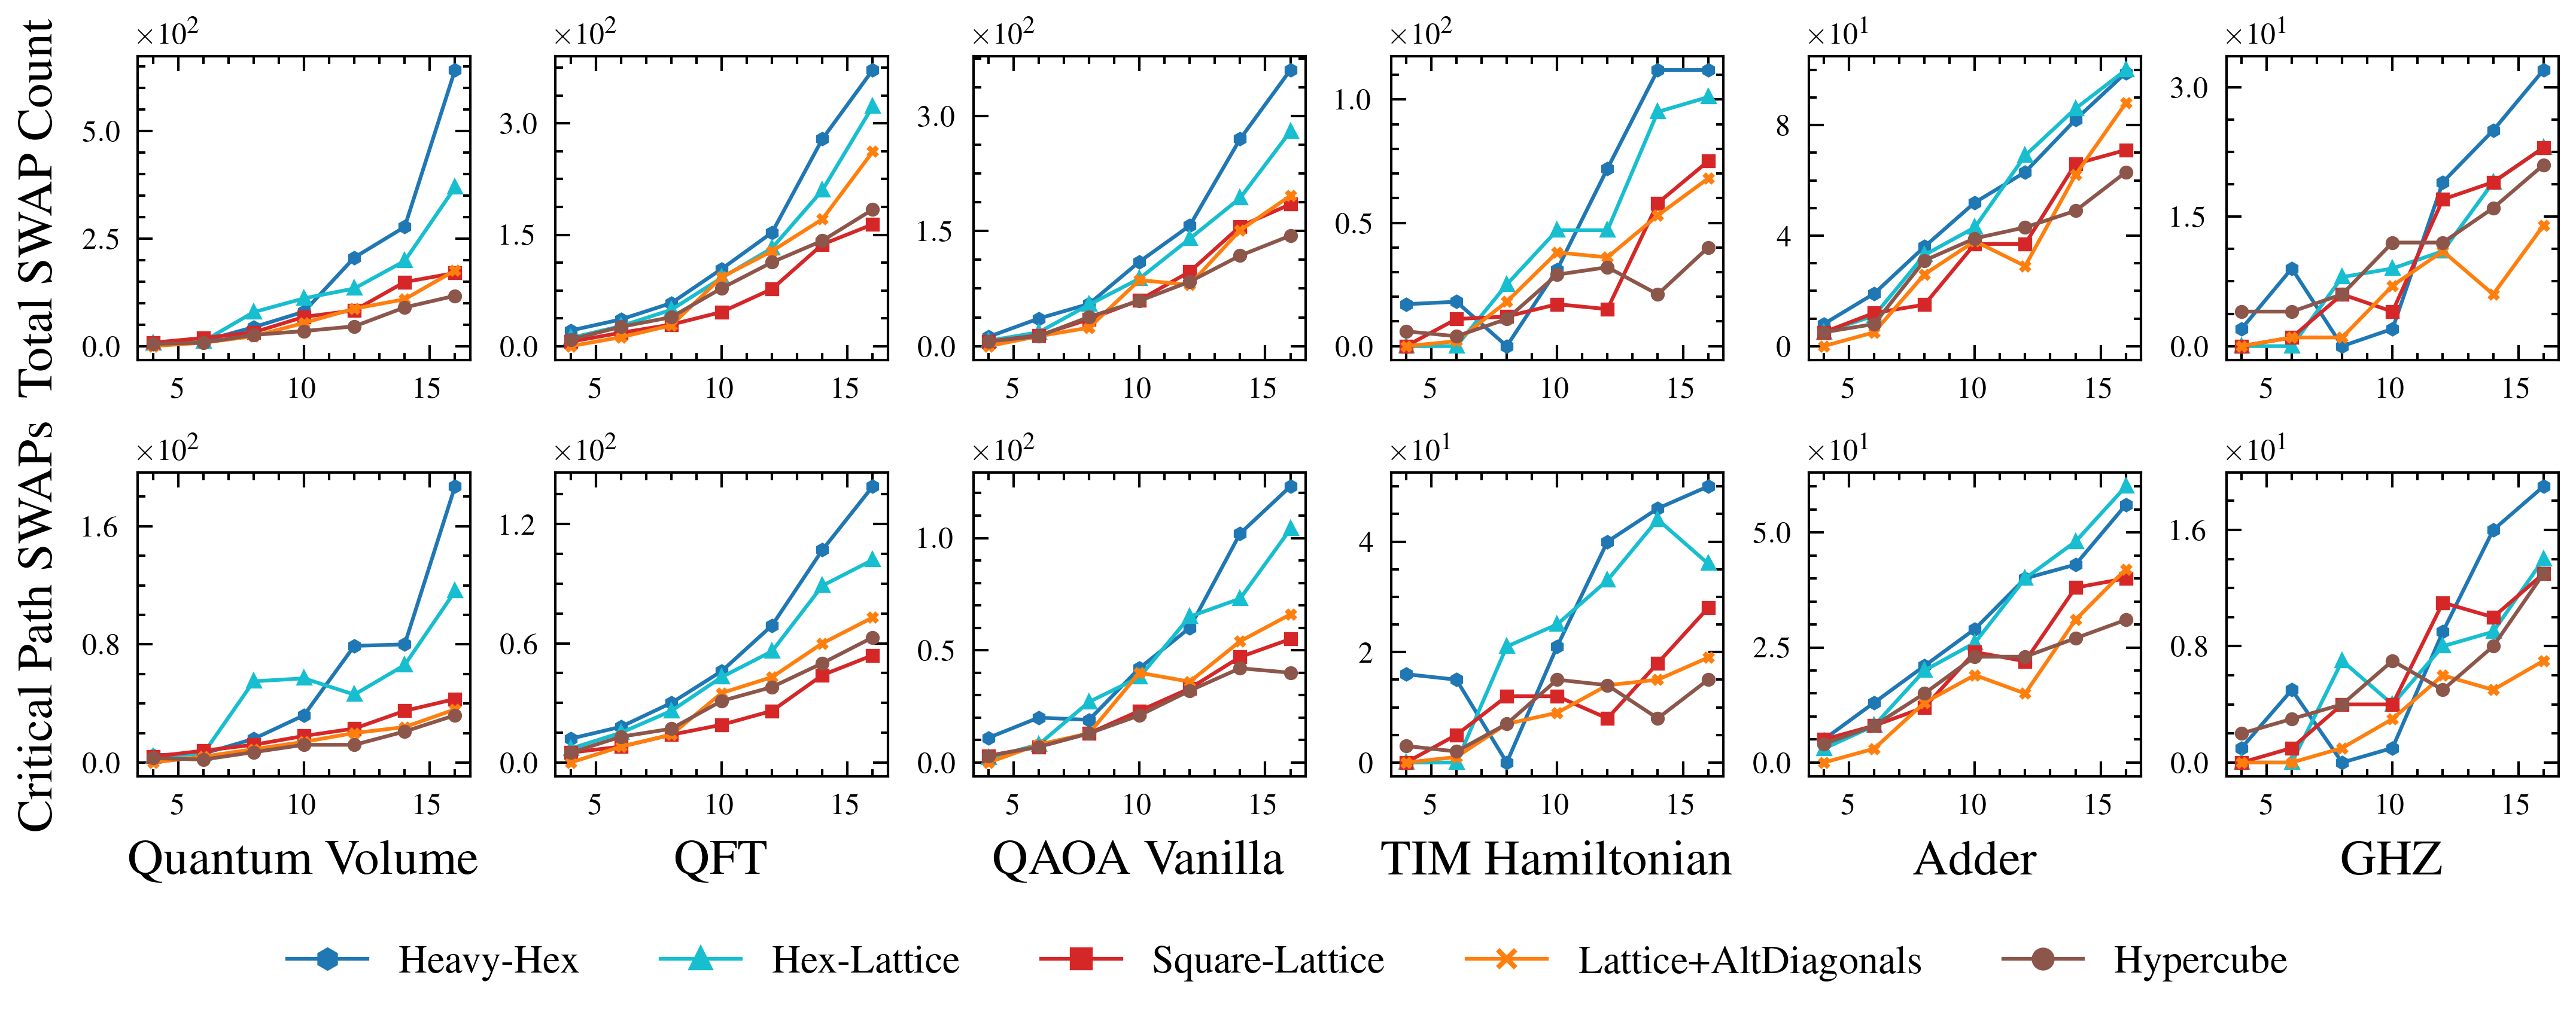

In [41]:
# #DANGER don't run before changing circuits q list
# from backend_suite_v2 import small_motivation_backends
# from circuit_suite import circuits
# for circuit_gen in circuits.values():
#     benchmark(
#         backends=small_motivation_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=False,
#         repeat=1
#     ) 
# plot_wrap(small_motivation_backends, circuits.keys(), motivation=True, plot_average=True)

Starting benchmark for Quantum_Volume
Starting benchmark for QFT
Starting benchmark for QAOA_Vanilla
Starting benchmark for TIM_Hamiltonian
Starting benchmark for Adder
Starting benchmark for GHZ


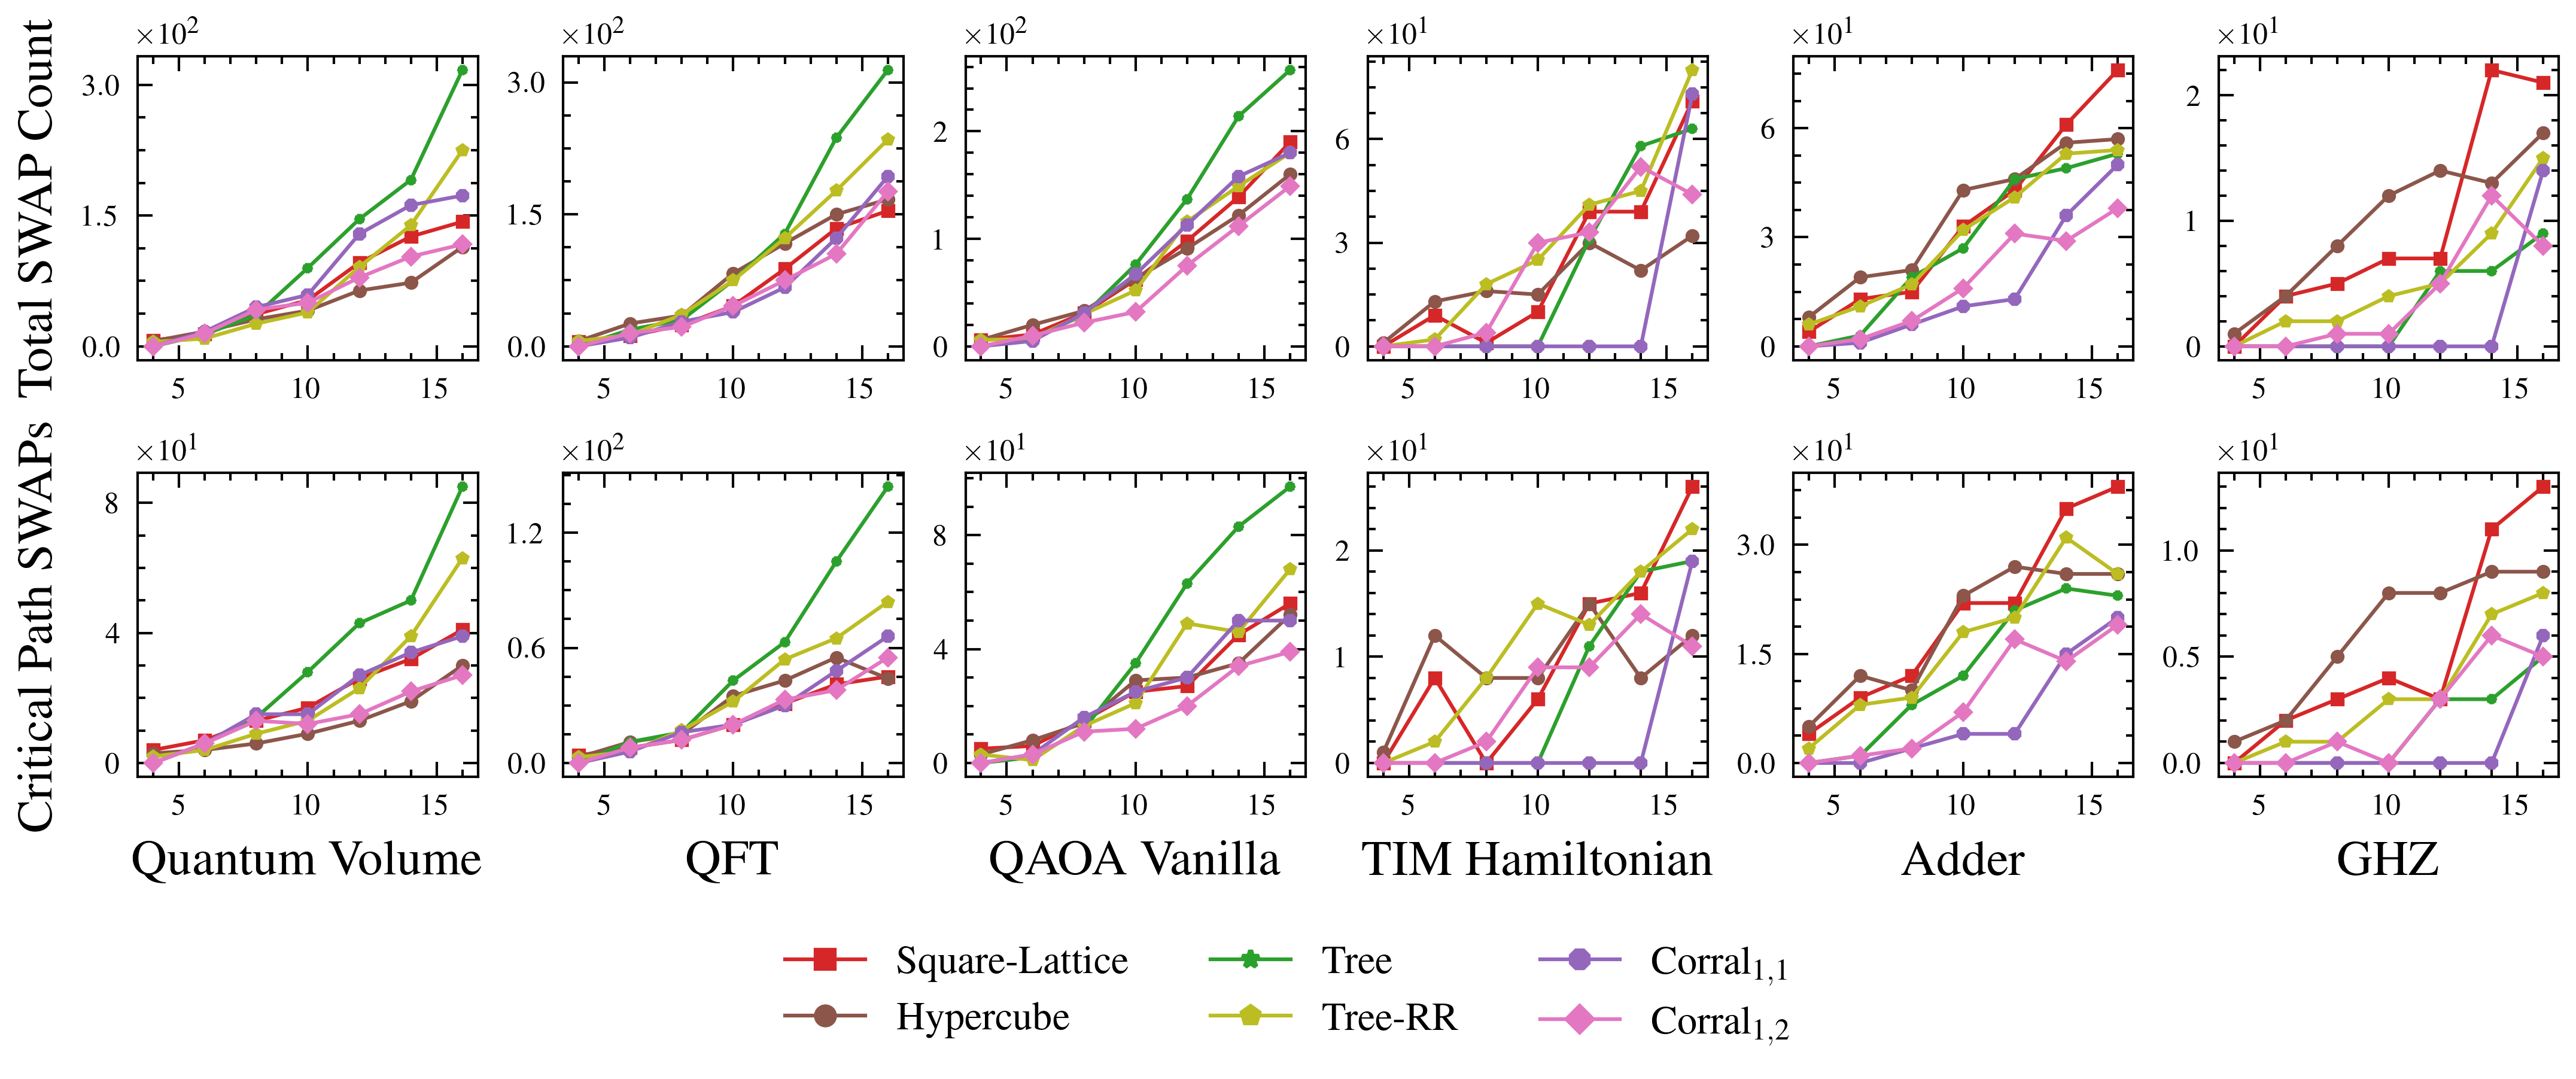

In [52]:
# ##DANGER don't run before changing circuits q list
# from backend_suite_v2 import small_results_backends
# from circuit_suite import circuits
# for circuit_gen in circuits.values():
#     benchmark(
#         backends=small_results_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=False,
#         repeat=1
#     ) 
# plot_wrap(small_results_backends, circuits.keys(), motivation=True, plot_average=True)

In [ ]:
# from backend_suite_v2 import beta_small_modular_backends
# from circuit_suite import circuits

# for circuit_gen in circuits.values():
#     benchmark(
#         backends=beta_small_modular_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=True,
#         repeat=1
#     )

# # edge_histogram(decomp_backends, circuit_gen.label)
# # circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
# plot_wrap(beta_small_modular_backends, circuits.keys(), motivation=True, plot_average=True)


In [ ]:
from backend_suite_v2 import decomp_backends
from circuit_suite import circuits
circuit_gen = circuits["QAOA_Vanilla"]
benchmark(backends=decomp_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
plot(decomp_backends, circuit_gen.label, duration=1)
#edge_histogram(decomp_backends, circuit_gen.label)
#circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [ ]:
# from backend_suite_v2 import modular_backends
# from circuit_suite import circuits
# circuit_gen = circuits["Quantum_Volume"]
# benchmark(backends=modular_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(modular_backends, circuit_gen.label, duration=1)
# #edge_histogram(decomp_backends, circuit_gen.label)
# #circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)


In [ ]:
# from backend_suite_v2 import industry_backends
# from circuit_suite import circuits

# for circuit_gen in circuits.values():
#     benchmark(
#         backends=industry_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=False,
#         repeat=1
#     )

# # edge_histogram(decomp_backends, circuit_gen.label)
# # circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
# plot_wrap(industry_backends, circuits.keys(), motivation=False, plot_average=True)


In [ ]:
# from backend_suite_v2 import motivation_backends
# from circuit_suite import circuits

# for circuit_gen in circuits.values():
#     benchmark(
#         backends=motivation_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=False,
#         repeat=1
#     )

# # edge_histogram(decomp_backends, circuit_gen.label)
# # circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
# plot_wrap(motivation_backends, circuits.keys(), motivation=True, plot_average=True)


In [ ]:
# from backend_suite_v2 import small_modular_backends
# from circuit_suite import circuits

# for circuit_gen in circuits.values():
#     benchmark(
#         backends=small_modular_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=False,
#         repeat=3
#     )

# # edge_histogram(decomp_backends, circuit_gen.label)
# # circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
# plot_wrap(small_modular_backends, circuits.keys(), motivation=True, plot_average=True)

In [ ]:
# plot_wrap(small_modular_backends, circuits.keys(), motivation=True, plot_average=False)


In [ ]:
# from backend_suite_v2 import beta_small_modular_backends
# from circuit_suite import circuits

# for circuit_gen in circuits.values():
#     benchmark(
#         backends=beta_small_modular_backends,
#         circuit_generator=circuit_gen,
#         continuously_save=True,
#         overwrite=False,
#         repeat=10
#     )

# # edge_histogram(decomp_backends, circuit_gen.label)
# # circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
# plot_wrap(beta_small_modular_backends, circuits.keys(), motivation=True, plot_average=True)


In [ ]:
# plot_wrap(beta_small_modular_backends, circuits.keys(), motivation=True, plot_average=False)

In [ ]:
# from backend_suite_v2 import motivation_backends
# from circuit_suite import circuits

# plot_wrap(motivation_backends, circuits.keys(), motivation=True)


# Edge Contention Tests

In [ ]:
# from backend_suite_v2 import dummy_backends
# from circuit_suite import circuits
# circuit_gen = circuits["QAOA_Vanilla"]
# benchmark(backends=dummy_backends, circuit_generator=circuit_gen, continuously_save=True, overwrite=False)
# plot(dummy_backends, circuit_gen.label)
# edge_histogram(dummy_backends, circuit_gen.label)
# circuit_gen.circuit_lambda(4).decompose().draw(output='mpl', reverse_bits=True)
